In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse

### Import data

In [2]:
# transaction date is imported as a date time field
df = pd.read_csv('data.csv', parse_dates=['transactiondate'])
df['value'] = round(df['value'],3)
df = df.set_index('transactiondate')
df.head()

,value
transactiondate,
2018-01-10 00:01:11,0.017
2018-01-10 00:01:57,0.029
2018-01-10 00:02:12,0.020
2018-01-10 00:02:16,0.042
2018-01-10 00:03:08,0.013


## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7362 entries, 2018-01-10 00:01:11 to 2018-01-12 05:00:59
Data columns (total 1 columns):
value    7362 non-null float64
dtypes: float64(1)
memory usage: 115.0 KB


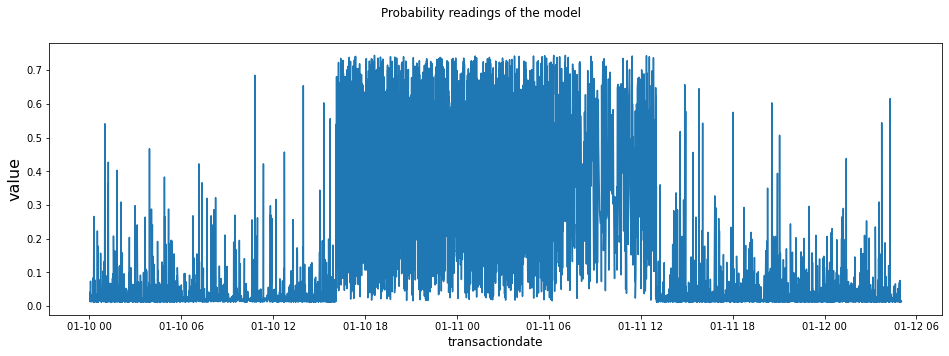

In [5]:
fig = plt.figure(figsize=(16,5))
fig.suptitle('Probability readings of the model', fontsize=12)
plt.plot(df['value'])    
plt.xlabel('transactiondate', fontsize=12)
plt.ylabel('value', fontsize=16)
plt.show()

In [6]:
# Check if there are duplicate values for transaction date
df.index.has_duplicates

True

In [7]:
# Check duplicate values in the data set
df[df.index.duplicated(keep=False)]

,value
transactiondate,
2018-01-10 00:15:54,0.028
2018-01-10 00:15:54,0.012
2018-01-10 01:01:10,0.018
2018-01-10 01:01:10,0.015
2018-01-10 01:39:33,0.164
...,...
2018-01-12 04:47:51,0.013
2018-01-12 04:52:21,0.023
2018-01-12 04:52:21,0.048


## Observations

- Data set has readings from 2018-01-10 00:01:11 to 2018-01-12 05:00:59 
- No null values observed
- 146 duplicate readings resulting in 291 rows containing duplicates
- There appears to be good distribution of high and low values (predicted probabilites) EXCEPT between 1/10 16:00 hours and 01/13 13:00 hours where there is abnormally higher percentage of high probability values between 0.5 and 0.7

## Clean duplicates 

In [8]:
# dropping ALL duplicte values 
df.index.drop_duplicates(keep = False) 

DatetimeIndex(['2018-01-10 00:01:11', '2018-01-10 00:01:57',
               '2018-01-10 00:02:12', '2018-01-10 00:02:16',
               '2018-01-10 00:03:08', '2018-01-10 00:03:26',
               '2018-01-10 00:03:29', '2018-01-10 00:03:57',
               '2018-01-10 00:03:58', '2018-01-10 00:04:02',
               ...
               '2018-01-12 04:55:16', '2018-01-12 04:55:30',
               '2018-01-12 04:55:38', '2018-01-12 04:55:43',
               '2018-01-12 04:55:50', '2018-01-12 04:56:30',
               '2018-01-12 04:57:26', '2018-01-12 04:57:48',
               '2018-01-12 04:59:36', '2018-01-12 05:00:59'],
              dtype='datetime64[ns]', name='transactiondate', length=7071, freq=None)

In [10]:
assert df.index.has_duplicates
assert df.isnull().sum().sum() == 0

### Resampling data by hour with mean

In [11]:
# Resample to hourly frequency, aggregating with mean
df_hourly_mean = df['value'].resample('H').mean()
df_hourly_mean = df_hourly_mean.reset_index()
df_hourly_mean.columns = ['transaction_hour', 'mean_value']
df_hourly_mean.head()

,transaction_hour,mean_value
0,2018-01-10 00:00:00,0.031589
1,2018-01-10 01:00:00,0.038081
2,2018-01-10 02:00:00,0.031296
3,2018-01-10 03:00:00,0.033795
4,2018-01-10 04:00:00,0.035687


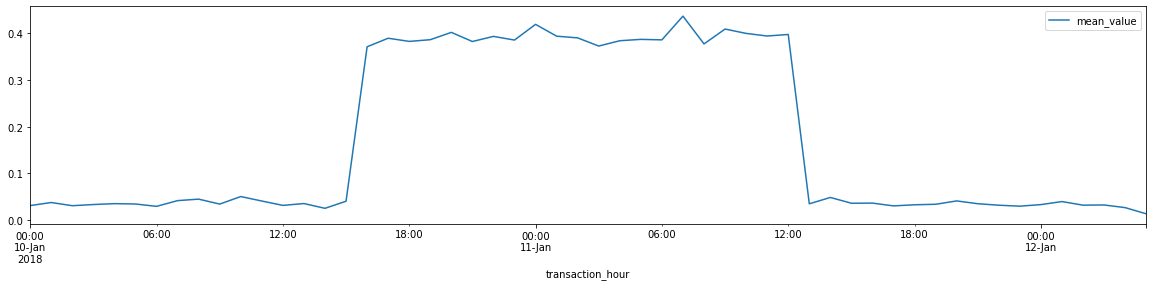

In [12]:
df_hourly_mean.plot(x = 'transaction_hour', y = 'mean_value',figsize = (20,4))

The resampled plot confirms an anomaly from 10-Jan 16:00 hrs to 11-Jan 13:00 hrs

### Determination of anomalous data and outage window

In [15]:
# Use clustering with eps (min_dist) = 0.2 to identify if the readings can be clustered into groups
# eps is chosen as 0.2 based on the data analyzed above

from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(min_samples = 2, eps = 0.2)

df_hourly_mean['cluster'] = outlier_detection.fit_predict(df_hourly_mean[['mean_value']])
df_hourly_mean

,transaction_hour,mean_value,cluster
0,2018-01-10 00:00:00,0.031589,0
1,2018-01-10 01:00:00,0.038081,0
2,2018-01-10 02:00:00,0.031296,0
3,2018-01-10 03:00:00,0.033795,0
4,2018-01-10 04:00:00,0.035687,0
5,2018-01-10 05:00:00,0.034914,0
6,2018-01-10 06:00:00,0.029892,0
7,2018-01-10 07:00:00,0.042129,0
8,2018-01-10 08:00:00,0.045311,0
9,2018-01-10 09:00:00,0.034746,0


Using Clustering, we get two clusters
Assuming Cluster = 0 is the normal data and Cluster = 1 anomalous data


In [16]:
# Find the "shifts" of data between two consecutive hours
# This can determine when a shift started and ended - implying start and end of outage
df_hourly_mean['cluster_shift'] = df_hourly_mean['cluster'].diff()
df_hourly_mean

,transaction_hour,mean_value,cluster,cluster_shift
0,2018-01-10 00:00:00,0.031589,0,NaN
1,2018-01-10 01:00:00,0.038081,0,0.0
2,2018-01-10 02:00:00,0.031296,0,0.0
3,2018-01-10 03:00:00,0.033795,0,0.0
4,2018-01-10 04:00:00,0.035687,0,0.0
5,2018-01-10 05:00:00,0.034914,0,0.0
6,2018-01-10 06:00:00,0.029892,0,0.0
7,2018-01-10 07:00:00,0.042129,0,0.0
8,2018-01-10 08:00:00,0.045311,0,0.0
9,2018-01-10 09:00:00,0.034746,0,0.0


In [17]:
# based on the cluster_shift field, scan through the data to determine the outage windows
# if cluster_shift == 1, an outage window begins. if cluster_shift = -1, the outage window ends
start = False
for x in df_hourly_mean.index:
    if df_hourly_mean.loc[x,'cluster_shift'] == 1 and start == False:
        print(f"Outage started at :{df_hourly_mean.loc[x,'transaction_hour']}")
        start = True
    elif df_hourly_mean.loc[x,'cluster_shift'] == -1 and start == True:
        print(f"Outage ended at :{df_hourly_mean.loc[x,'transaction_hour']}")
        start = False        

Outage started at :2018-01-10 16:00:00
Outage ended at :2018-01-11 13:00:00


### Consolidated function

In [19]:
from sklearn.cluster import DBSCAN

def find_outage_windows(df):
    
    df1 = df.copy()
    df1.index.drop_duplicates(keep = False) 
    
    try:    
        assert df1.index.has_duplicates
        assert df1.isnull().sum().sum() == 0        
    except:
        print("Data cleanup required - either duplicates or null values")
    
    # Resample to hourly frequency, aggregating with mean
    df_hourly_mean = df1['value'].resample('H').mean()
    df_hourly_mean = df_hourly_mean.reset_index()
    df_hourly_mean.columns = ['transaction_hour', 'mean_value']

    outlier_detection = DBSCAN(min_samples = 2, eps = 0.2)
    df_hourly_mean['cluster'] = outlier_detection.fit_predict(df_hourly_mean[['mean_value']])
    df_hourly_mean['cluster_shift'] = df_hourly_mean['cluster'].diff()

    start = False
    for x in df_hourly_mean.index:
        if df_hourly_mean.loc[x,'cluster_shift'] == 1 and start == False:
            print(f"Outage started at :{df_hourly_mean.loc[x,'transaction_hour']}")
            start = True
        elif df_hourly_mean.loc[x,'cluster_shift'] == -1 and start == True:
            print(f"Outage ended at :{df_hourly_mean.loc[x,'transaction_hour']}")
            start = False


df = pd.read_csv('data.csv', parse_dates=['transactiondate'])
df['value'] = round(df['value'],3)
df = df.set_index('transactiondate')

find_outage_windows(df)

Outage started at :2018-01-10 16:00:00
Outage ended at :2018-01-11 13:00:00
